<a href="https://colab.research.google.com/github/le11nguyen/Sentiment-analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load dataset
import pandas as pd

df = pd.read_csv('/content/IMDB-Dataset.csv', on_bad_lines='skip')
# Remove duplicate rows
df = df.drop_duplicates ()

In [2]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [3]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.7 MB/s eta 0:00:00


In [4]:
import re
import string
import nltk
nltk . download ('stopwords')
nltk . download ('wordnet')
from nltk . corpus import stopwords
from nltk . stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set( stopwords.words ('english'))

# Expanding contractions
def expand_contractions ( text ) :
  return contractions.fix( text )

# Function to clean data
def preprocess_text ( text ) :

  wl = WordNetLemmatizer ()

  soup = BeautifulSoup (text , "html.parser") # Removing html tags
  text = soup . get_text ()
  text = expand_contractions ( text ) # Expanding chatwords and contracts clearing contractions
  emoji_clean = re. compile ("["
  u"\ U0001F600 -\ U0001F64F " # emoticons
  u"\ U0001F300 -\ U0001F5FF " # symbols & pictographs
  u"\ U0001F680 -\ U0001F6FF " # transport & map symbols
  u"\ U0001F1E0 -\ U0001F1FF " # flags (iOS)
  u"\ U00002702 -\ U000027B0 "
  u"\ U000024C2 -\ U0001F251 "
  "]+", flags =re. UNICODE )
  text = emoji_clean . sub(r'',text )
  text = re.sub (r'\.(?=\ S)', '. ',text ) #add space after full stop
  text = re.sub (r'http \S+', '', text ) # remove urls
  text = "". join ([word . lower () for word in text if word not in string . punctuation
  ]) # remove punctuation and make text lowercase
  text = " ". join ([wl. lemmatize ( word ) for word in text . split () if word not in stop and word .isalpha () ]) # lemmatize
  return text

df['review'] = df['review']. apply ( preprocess_text )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-4-d21fed7a0114>:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup (text , "html.parser") # Removing html tags


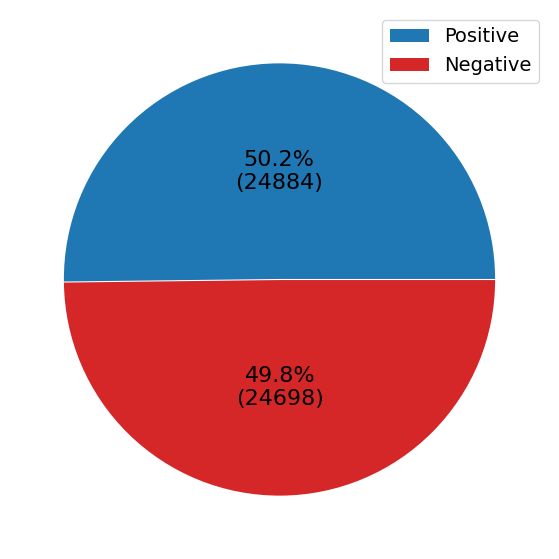

In [5]:
import numpy as np
import seaborn as sns
import matplotlib . pyplot as plt

# Creating autocpt arguments
def func (pct , allvalues ) :
  absolute = int( pct / 100.* np. sum( allvalues ) )
  return "{:.1f}%\n({:d})".format (pct , absolute ) # removed space between : and .1f

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment' ] == 'negative'])

data = [ freq_pos , freq_neg ]

labels = ['positive', 'negative']
# Create pie chart
pie , ax = plt . subplots ( figsize =[11 ,7])
plt . pie(x=data , autopct = lambda pct: func (pct , data ) , explode =[0.0025]*2 ,
          pctdistance =0.5 , colors =[ sns. color_palette () [0] , 'tab:red'] , textprops ={ 'fontsize': 16}) # removed space in 'tab:red'
# plt . title ( ’ Frequencies of sentiment labels ’, fontsize =14 , fontweight = ’ bold ’)
labels = [r'Positive', r'Negative']
plt . legend (labels , loc ="best", prop ={'size': 14})
pie . savefig ("PieChart.png")
plt . show ()

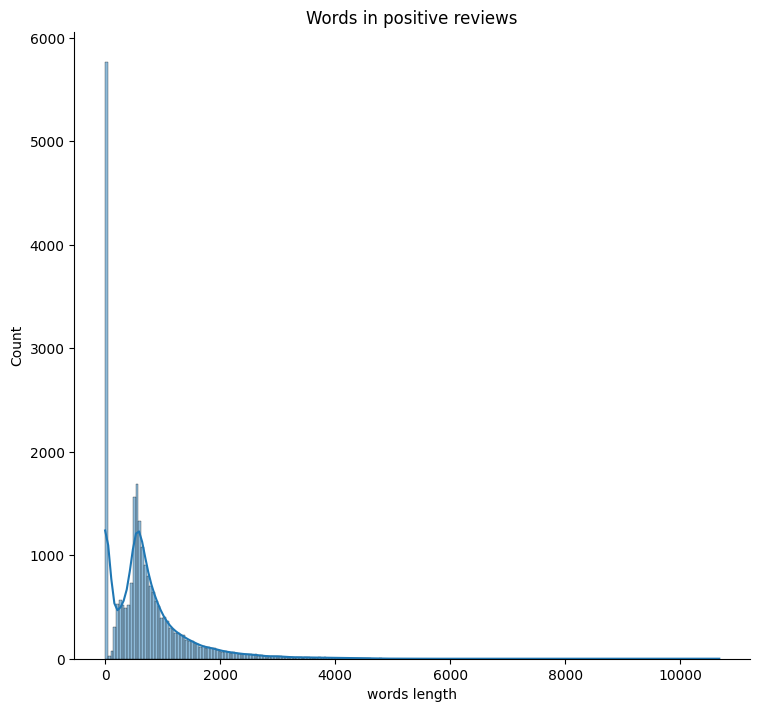

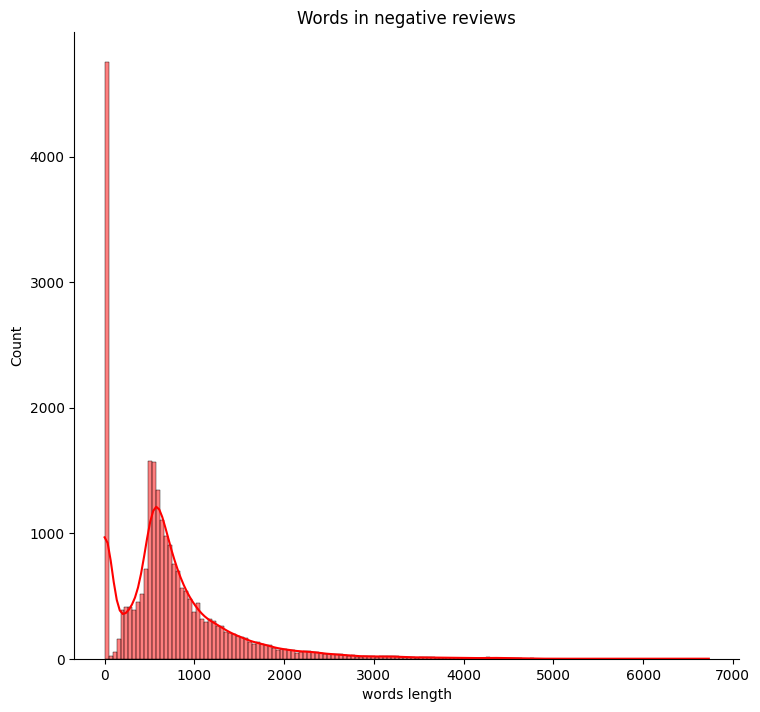

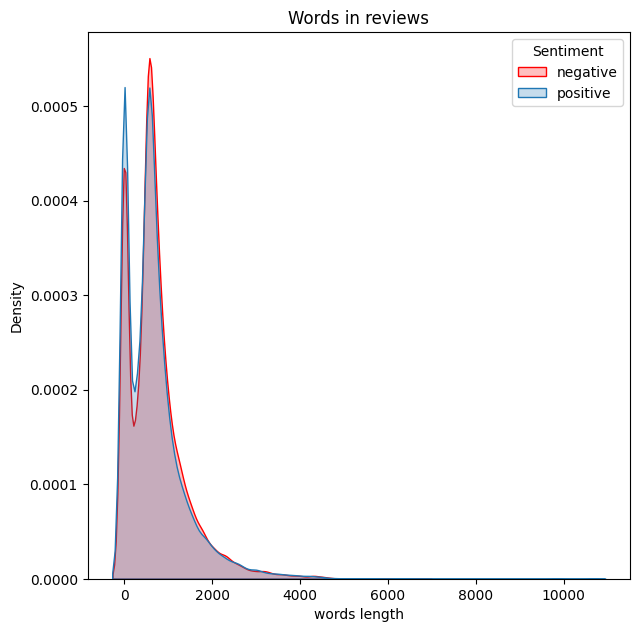

In [14]:
words_len = df['review'].map( lambda x: len(x) )
df_temp = df. copy ()
df_temp ['words length'] = words_len

hist_positive = sns. displot ( data = df_temp [ df_temp ['sentiment'] == 'positive'] ,
                              x="words length", hue="sentiment", kde=True , height =7 , aspect =1.1 , legend =False
                               ) .set ( title ='Words in positive reviews')
plt . show ( hist_positive )

hist_negative = sns. displot ( data = df_temp [ df_temp ['sentiment'] == 'negative'] ,
                              x="words length", hue="sentiment", kde=True , height =7 , aspect =1.1 , legend =False , palette =[ 'red']
                               ) .set ( title ='Words in negative reviews')
plt . show ( hist_negative )

plt . figure ( figsize =(7 ,7.1) )
kernel_distibution_number_words_plot = sns. kdeplot (data = df_temp , x="words length", hue="sentiment",
                                                     fill =True , palette =[ sns .color_palette () [0] , 'red']) .set ( title ='Words in reviews')
plt . legend ( title ='Sentiment', labels =[ 'negative', 'positive'])
plt . show ( kernel_distibution_number_words_plot )

In [18]:
from sklearn . model_selection import train_test_split
from sklearn . feature_extraction . text import TfidfVectorizer
from sklearn . preprocessing import LabelEncoder

label_encode = LabelEncoder ()

y_data = label_encode . fit_transform (df['sentiment' ])
x_data = df['review']

x_train , x_test , y_train , y_test = train_test_split (x_data , y_data , test_size =0.2 , random_state =42)

In [19]:
tfidf_vectorizer = TfidfVectorizer ( max_features =10000)
tfidf_vectorizer .fit ( x_train , y_train )

x_train_encoded = tfidf_vectorizer . transform ( x_train )
x_test_encoded = tfidf_vectorizer . transform ( x_test )

In [21]:
from sklearn . tree import DecisionTreeClassifier
from sklearn . ensemble import RandomForestClassifier
from sklearn . metrics import accuracy_score

dt_classifier = DecisionTreeClassifier (
    criterion ='entropy',random_state =42)
dt_classifier . fit( x_train_encoded , y_train )
y_pred = dt_classifier . predict ( x_test_encoded )
accuracy_score (y_pred , y_test )
rf_classifier = RandomForestClassifier (random_state =42)
rf_classifier . fit( x_train_encoded , y_train )
y_pred = rf_classifier . predict ( x_test_encoded )
accuracy_score (y_pred , y_test )

0.5019663204598165